In [16]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import streamlit as st
import joblib  # To save the model

In [17]:
df = pd.read_csv('loan_prediction.csv')

In [18]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)

# Data Cleaning

In [19]:
df.shape

(614, 13)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 67.2+ KB


In [21]:
df.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


* Conert columns [Gender, Married, Dependents, Education, Self_Employed, Property_Area, and Loan_Status] from "Object" to "Categorical" 
* Correctly rename columns [ApplicantIncome	CoapplicantIncome	LoanAmount] to [Applicant_Income	Co_applicant_Income	Loan_Amount]

In [22]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

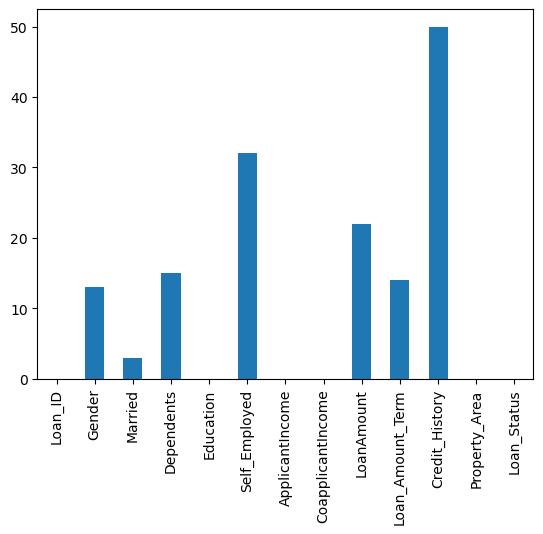

In [23]:
df.isna().sum().plot(kind = 'bar');

In [24]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace = True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace = True)

In [25]:
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace = True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean(), inplace = True)
df['Credit_History'].fillna(df['Credit_History'].mean(), inplace = True)

In [26]:
df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [27]:
df.rename(columns = {'LoanAmount':'Loan_Amount', 
                     'ApplicantIncome':'Applicant_Income', 
                     'CoapplicantIncome':'Co-Applicant_Income'}, inplace = True)

In [28]:
df['Dependents'].value_counts()

0     360
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [29]:
def values(values):
    if values == '3+':
        return 3
    else:
        return values
df['Dependents'] = df['Dependents'].map(values)

In [30]:
df['Dependents'].value_counts()

0    360
1    102
2    101
3     51
Name: Dependents, dtype: int64

<Axes: >

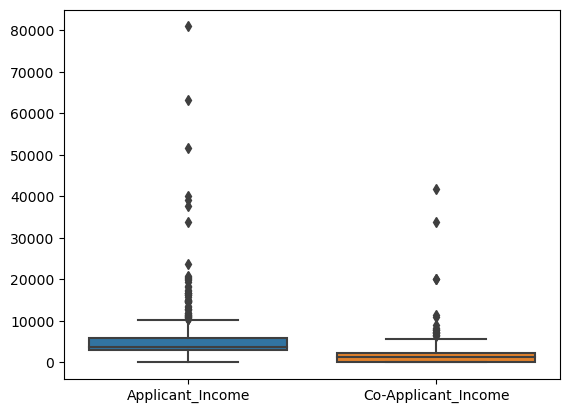

In [31]:
sns.boxplot(df[['Applicant_Income', 'Co-Applicant_Income']])

In [32]:
from scipy.stats import iqr

# Define the columns containing numerical variables
columns = ['Applicant_Income', 'Co-Applicant_Income']

# Calculate the IQR for each column
iqr_values = iqr(df[columns], axis=0)

# Calculate the lower and upper bounds for outlier detection
lower_bound = df[columns].quantile(0.25) - 1 * iqr_values
upper_bound = df[columns].quantile(0.75) + 1 * iqr_values

# Filter out the outliers from the DataFrame
df = df[~((df[columns] <= lower_bound) | (df[columns] >= upper_bound)).any(axis=1)]

<Axes: >

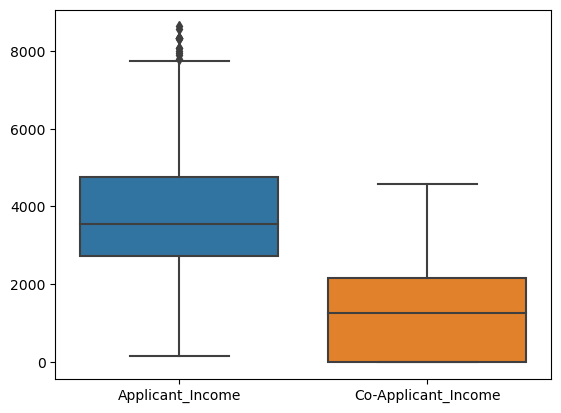

In [33]:
sns.boxplot(df[['Applicant_Income', 'Co-Applicant_Income']])

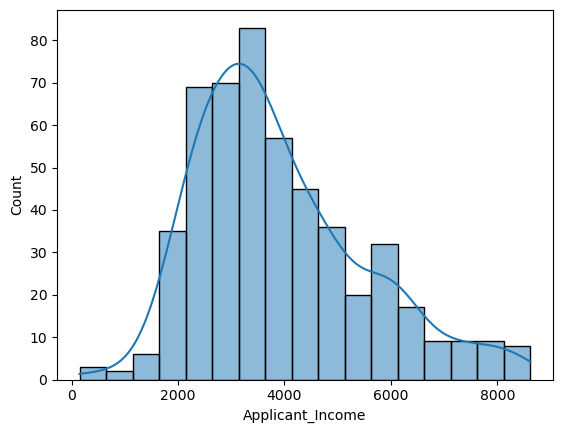

In [34]:
sns.histplot(data = df['Applicant_Income'], kde = True);

In [35]:
from scipy.stats import iqr

# Define the columns containing numerical variables
columns = ['Applicant_Income', 'Co-Applicant_Income']

# Calculate the IQR for each column
iqr_values = iqr(df[columns], axis=0)

# Calculate the lower and upper bounds for outlier detection
lower_bound = df[columns].quantile(0.25) - 1.4 * iqr_values
upper_bound = df[columns].quantile(0.75) + 1.4 * iqr_values

# Filter out the outliers from the DataFrame
df = df[~((df[columns] <= lower_bound) | (df[columns] >= upper_bound)).any(axis=1)]

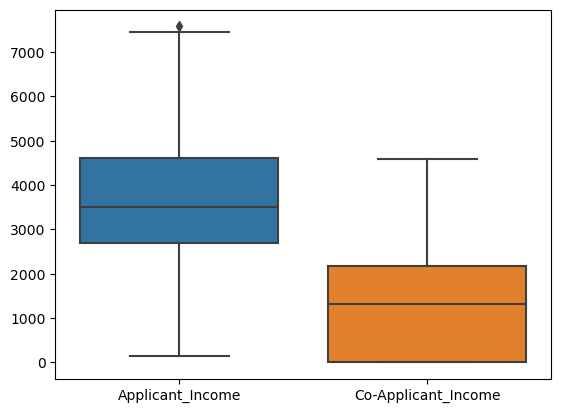

In [36]:
sns.boxplot(df[['Applicant_Income', 'Co-Applicant_Income']]);

In [37]:
order_of_column = ['Loan_ID', 'Applicant_Income', 'Co-Applicant_Income', 'Loan_Amount', 'Loan_Amount_Term',
                 'Dependents', 'Education', 'Gender', 'Married', 'Self_Employed',
                 'Credit_History', 'Property_Area', 'Loan_Status']

In [38]:
df = df.reindex(columns = order_of_column)

# Exploratory Data Analysis

In [39]:
df[['Applicant_Income', 'Co-Applicant_Income', 'Loan_Amount', 'Loan_Amount_Term']].describe()

,Applicant_Income,Co-Applicant_Income,Loan_Amount,Loan_Amount_Term
count,492.000000,492.000000,492.000000,492.000000
mean,3747.843496,1285.381951,123.631770,343.390244
std,1394.605003,1289.931239,44.851465,64.599047
min,150.000000,0.000000,9.000000,12.000000
25%,2698.750000,0.000000,98.000000,360.000000
50%,3498.500000,1316.000000,120.000000,360.000000
75%,4618.250000,2167.250000,146.412162,360.000000
max,7578.000000,4583.000000,330.000000,480.000000


In [40]:
cat_cols = df[['Dependents', 'Education', 'Gender', 'Married', 'Self_Employed',  'Property_Area', 'Loan_Status']]

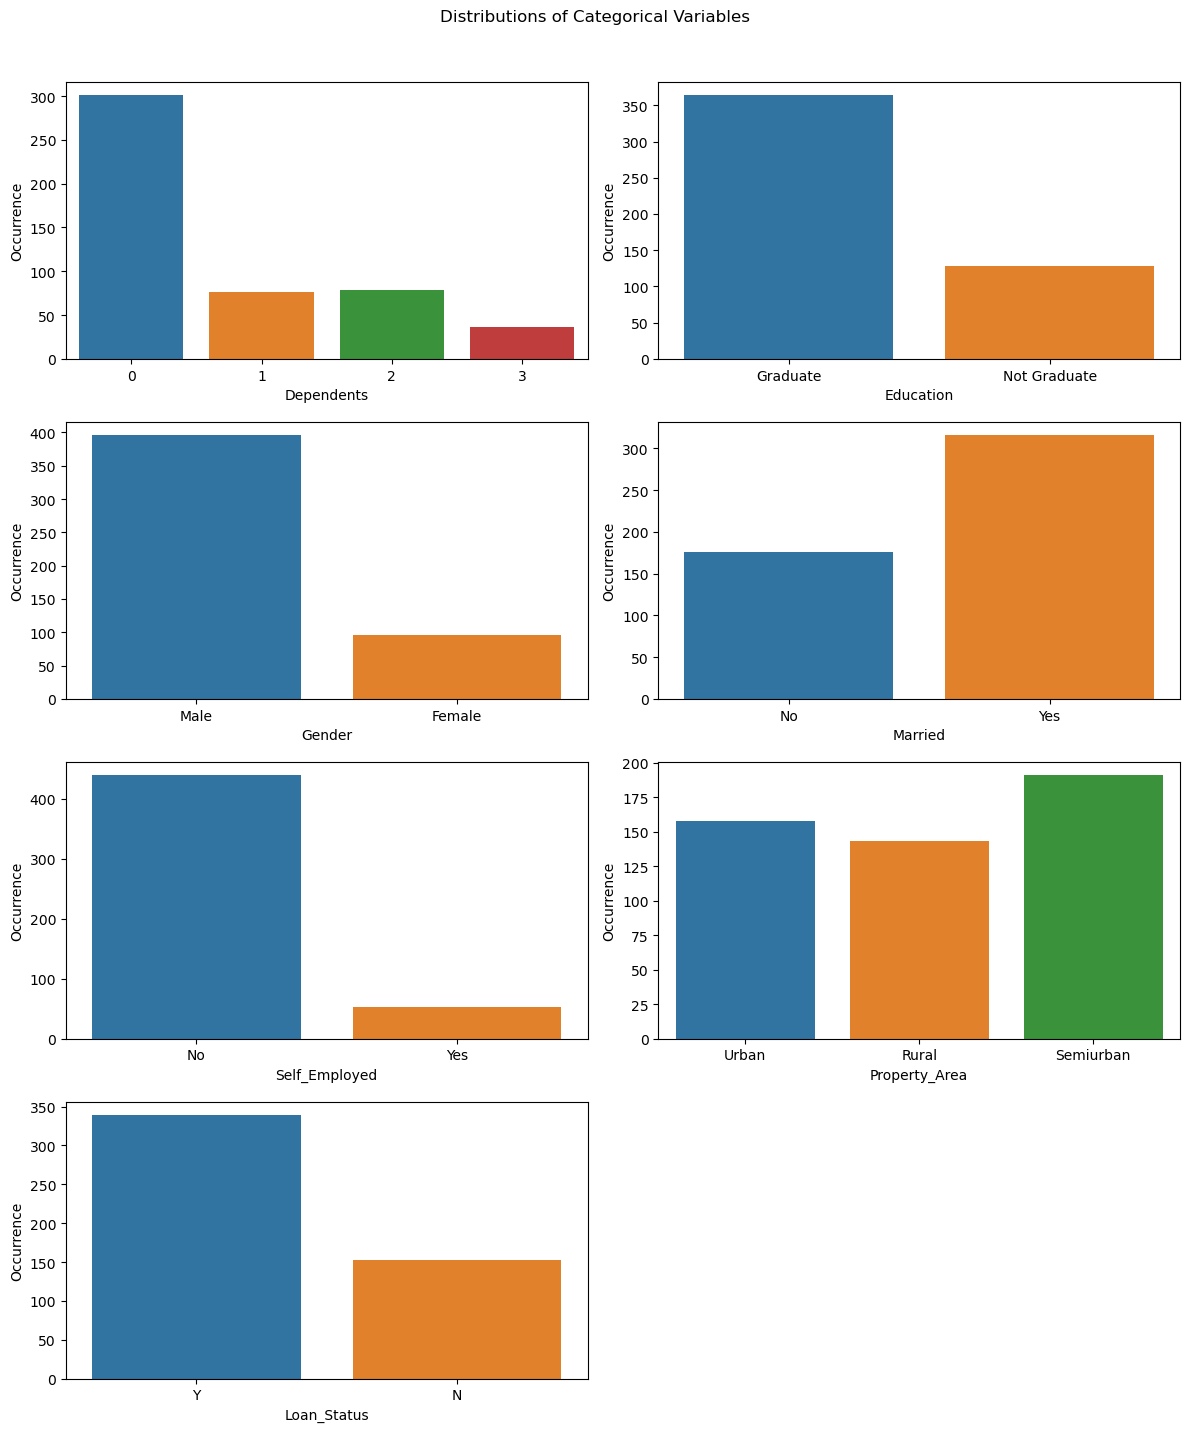

In [41]:

plt.figure(figsize=(12, 14))
for i, var in enumerate(cat_cols, 1):
    plt.subplot(4, 2, i)
    sns.countplot(data=df, x=var)
    plt.xlabel(var)
    plt.ylabel('Occurrence')

plt.suptitle('Distributions of Categorical Variables', y=1.02)
plt.tight_layout()
plt.show()

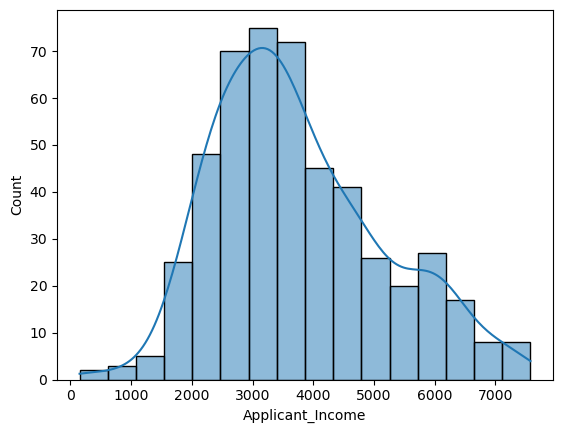

In [42]:
sns.histplot(data = df['Applicant_Income'], kde = True);

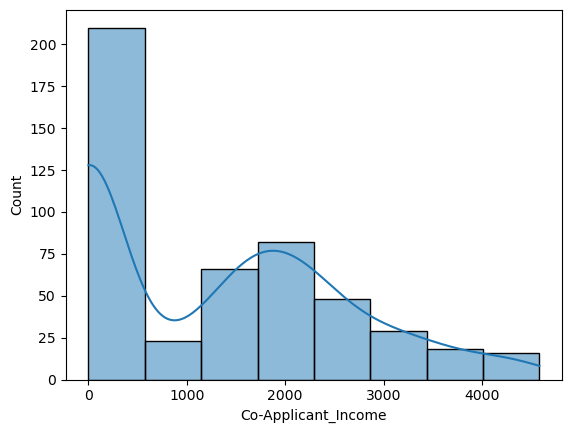

In [43]:
sns.histplot(data = df['Co-Applicant_Income'], bins = 8, kde = True);

This is Log Normal Distribution. Will need to be log-transformed. Although it won't seriously impact the predictability

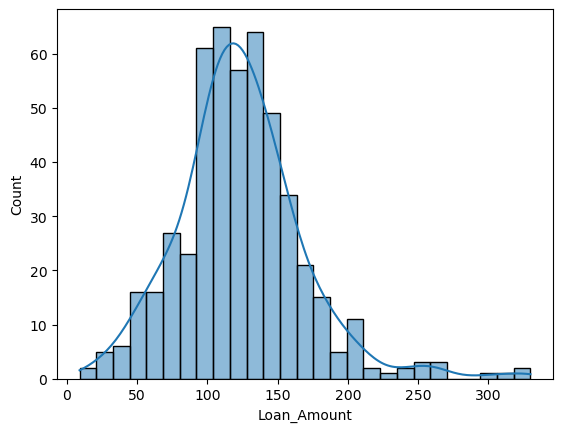

In [44]:
sns.histplot(data = df['Loan_Amount'], kde = True);

In [45]:
residence = df.groupby(['Property_Area', 'Loan_Status']).size()

total = df.groupby('Property_Area').size()

approval_by_residence = round(residence / total * 100, 1)

print(approval_by_residence.sort_values())


credit_2_loan = px.histogram(df, 
                             x='Property_Area', 
                             color='Loan_Status',
                             barmode='group',
                             color_discrete_sequence=px.colors.sequential.Rainbow,
                             title='Loan Status vs Residence')

credit_2_loan.update_xaxes(title_text='Residence')
credit_2_loan.update_yaxes(title_text='Approval Rate')


credit_2_loan.show();

Property_Area  Loan_Status
Semiurban      N              22.0
Urban          N              34.2
Rural          N              39.9
               Y              60.1
Urban          Y              65.8
Semiurban      Y              78.0
dtype: float64


In [46]:

education = df.groupby(['Education', 'Loan_Status']).size()

total = df.groupby('Education').size()

approval_by_education = round(education / total * 100, 1)

print(approval_by_education.sort_values())


credit_2_loan = px.histogram(df, 
                             x='Education', 
                             color='Loan_Status',
                             barmode='group',
                             color_discrete_sequence=px.colors.sequential.Rainbow,
                             title='Loan Status vs Education')

credit_2_loan.update_xaxes(title_text='Education')
credit_2_loan.update_yaxes(title_text='Approval Rate')


credit_2_loan.show();

Education     Loan_Status
Graduate      N              28.3
Not Graduate  N              39.1
              Y              60.9
Graduate      Y              71.7
dtype: float64


In [47]:
married = df.groupby(['Married', 'Loan_Status']).size()

total = df.groupby('Married').size()

approval_by_married = round(married / total * 100, 1)

print(approval_by_married.sort_values())


credit_2_loan = px.histogram(df, 
                             x='Married', 
                             color='Loan_Status',
                             barmode='group',
                             color_discrete_sequence=px.colors.sequential.Rainbow,
                             title='Loan Status vs Marrital Status')

credit_2_loan.update_xaxes(title_text='Married')
credit_2_loan.update_yaxes(title_text='Approval Rate')


credit_2_loan.show();


Married  Loan_Status
Yes      N              28.5
No       N              35.8
         Y              64.2
Yes      Y              71.5
dtype: float64


In [48]:
dependents = df.groupby(['Dependents', 'Loan_Status']).size()

total = df.groupby('Dependents').size()

approval_by_dependents = round(dependents / total * 100, 1)

print(approval_by_dependents)

credit_2_loan = px.histogram(df, 
                             x='Dependents', 
                             color='Loan_Status',
                             barmode='group',
                             color_discrete_sequence=px.colors.sequential.Rainbow,
                             title='Loan Status vs No. of Dependents')

credit_2_loan.update_xaxes(title_text='Dependents')
credit_2_loan.update_yaxes(title_text='Approval Rate')


credit_2_loan.show();


Dependents  Loan_Status
3           N              36.1
            Y              63.9
0           N              30.6
            Y              69.4
1           N              32.9
            Y              67.1
2           N              29.1
            Y              70.9
dtype: float64


In [49]:
employed = df.groupby(['Self_Employed', 'Loan_Status']).size()

total = df.groupby('Self_Employed').size()

approval_by_employment = round(employed / total * 100, 1)

print(approval_by_employment)

credit_2_loan = px.histogram(df, 
                             x='Self_Employed', 
                             color='Loan_Status',
                             barmode='group',
                             color_discrete_sequence=px.colors.sequential.Rainbow,
                             title='Loan Status vs No. of Employed')

credit_2_loan.update_xaxes(title_text='Self_Employed')
credit_2_loan.update_yaxes(title_text='Approval Rate')


credit_2_loan.show();

Self_Employed  Loan_Status
No             N              30.8
               Y              69.2
Yes            N              34.0
               Y              66.0
dtype: float64


In [50]:
gender = df.groupby(['Gender', 'Loan_Status']).size()

total = df.groupby('Gender').size()

approval_by_gender = round(gender / total * 100, 1)

print(approval_by_gender)

credit_2_loan = px.histogram(df, 
                             x='Gender', 
                             color='Loan_Status',
                             barmode='group',
                             color_discrete_sequence=px.colors.sequential.Rainbow,
                             title='Loan Status vs Gender')

credit_2_loan.update_xaxes(title_text='Gender')
credit_2_loan.update_yaxes(title_text='Approval Rate')


credit_2_loan.show();

Gender  Loan_Status
Female  N              34.4
        Y              65.6
Male    N              30.3
        Y              69.7
dtype: float64


In [51]:
income = df.groupby(['Applicant_Income', 'Loan_Status']).size()

total = df.groupby('Applicant_Income').size()

approval_by_income = round(income / total * 100, 1)

credit_2_loan = px.histogram(df, 
                             x='Applicant_Income', 
                             color='Loan_Status',
                             barmode='group',
                             color_discrete_sequence=px.colors.sequential.Rainbow,
                             title='Loan Status vs Income')

credit_2_loan.update_xaxes(title_text='Applicant_Income')
credit_2_loan.update_yaxes(title_text='Approval Rate')


credit_2_loan.show();

In [52]:
income2 = df.groupby(['Co-Applicant_Income', 'Loan_Status']).size()

total = df.groupby('Co-Applicant_Income').size()

approval_by_income = round(income2 / total * 100, 1)

credit_2_loan = px.histogram(df, 
                             x='Co-Applicant_Income', 
                             color='Loan_Status',
                             barmode='group',
                             color_discrete_sequence=px.colors.sequential.Rainbow,
                             title='Loan Status vs Income')

credit_2_loan.update_xaxes(title_text='Co-Applicant_Income')
credit_2_loan.update_yaxes(title_text='Approval Rate')


credit_2_loan.show();

In [53]:
credit_history = df.groupby(['Credit_History', 'Loan_Status']).size()

total = df.groupby('Credit_History').size()

approval_by_credit = round(credit_history / total * 100, 1)

credit_2_loan = px.histogram(df, 
                             x='Credit_History', 
                             color='Loan_Status',
                             barmode='group',
                             color_discrete_sequence=px.colors.sequential.Rainbow,
                             title='Loan Status vs Credit_History')

credit_2_loan.update_xaxes(title_text='Credit_History')
credit_2_loan.update_yaxes(title_text='Approval Rate')


credit_2_loan.show();

In [54]:
loan_term = df.groupby(['Loan_Amount_Term', 'Loan_Status']).size()

total = df.groupby('Loan_Amount_Term').size()

approval_by_term = round(loan_term / total * 100, 1)

credit_2_loan = px.histogram(df, 
                             x='Loan_Amount_Term', 
                             color='Loan_Status',
                             barmode='group',
                             color_discrete_sequence=px.colors.sequential.Rainbow,
                             title='Loan Status vs Loan_Amount_Term')

credit_2_loan.update_xaxes(title_text='Loan_Amount_Term')
credit_2_loan.update_yaxes(title_text='Approval Rate')


credit_2_loan.show();

In [55]:
loan_term = df.groupby(['Loan_Amount', 'Loan_Status']).size()

total = df.groupby('Loan_Amount').size()

approval_by_term = round(loan_term / total * 100, 1)

credit_2_loan = px.histogram(df, 
                             x='Loan_Amount', 
                             color='Loan_Status',
                             barmode='group',
                             color_discrete_sequence=px.colors.sequential.Rainbow,
                             title='Loan Status vs Loan_Amount')

credit_2_loan.update_xaxes(title_text='Loan_Amount')
credit_2_loan.update_yaxes(title_text='Approval Rate')


credit_2_loan.show();

# Feature Selection

In [56]:
cat_col = df[['Education', 'Gender', 'Married', 'Self_Employed',  'Property_Area', 'Loan_Status']]

In [57]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['category']).columns

le = LabelEncoder()

for col in cat_col:
    df[col] = le.fit_transform(df[col])


In [58]:
df['Dependents'] = df['Dependents'].astype('int64')

In [59]:
df.head()

,Loan_ID,Applicant_Income,Co-Applicant_Income,Loan_Amount,Loan_Amount_Term,Dependents,Education,Gender,Married,Self_Employed,Credit_History,Property_Area,Loan_Status
0,LP001002,5849,0.0,146.412162,360.0,0,0,1,0,0,1.0,2,1
1,LP001003,4583,1508.0,128.000000,360.0,1,0,1,1,0,1.0,0,0
2,LP001005,3000,0.0,66.000000,360.0,0,0,1,1,1,1.0,2,1
3,LP001006,2583,2358.0,120.000000,360.0,0,1,1,1,0,1.0,2,1
4,LP001008,6000,0.0,141.000000,360.0,0,0,1,0,0,1.0,2,1


In [60]:
df.drop(columns = 'Loan_ID', axis = 1, inplace = True)

X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

In [61]:
# Create a SelectKBest object with the chi2 (chi-square) test as the scoring function

k = 5  # Choose the top 5 features
selector_chi2 = SelectKBest(score_func=chi2, k=k)

# Fitting the on the training data selector and transforming the features
X_selected_chi2 = selector_chi2.fit_transform(X, y)

# Get the selected feature names
chi2_features = X.columns[selector_chi2.get_support()]
chi2_features

Index(['Applicant_Income', 'Co-Applicant_Income', 'Loan_Amount', 'Education',
       'Credit_History'],
      dtype='object')

In [62]:
# Create a SelectPercentile object with the ANOVA (f_classif) test as the scoring function

percentile = 50  # Choose the top 50% percentile features)
selector_anova = SelectPercentile(score_func=f_classif, percentile=percentile)

# Fit the selector on the training data and transform the features
X_selected_anova = selector_anova.fit_transform(X, y)

# Get the selected feature names
anova_features = X.columns[selector_anova.get_support()]
anova_features

Index(['Co-Applicant_Income', 'Loan_Amount', 'Education', 'Married',
       'Credit_History'],
      dtype='object')

In [63]:
# Splitting the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into 60% training and 20% validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [64]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # C is the inverse of the regularization strength (1/λ)
    'penalty': ['l1'],  # Use L1 (LASSO) regularization
    'solver': ['liblinear']  # Use 'liblinear' solver for L1 regularization
}

# Create the LASSO Logistic Regression model
lasso_logreg = LogisticRegression()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lasso_logreg, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the GridSearchCV
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


the combination of C = 1, penalty = 'l1', and solver = 'liblinear' yielded the best performance on the given dataset based on the selected evaluation metric

In [65]:
from sklearn.metrics import accuracy_score

In [66]:
# Calculate the proportion of the majority class in the target variable
majority_class_percentage = y_train.value_counts(normalize=True)[0]

# Predict the majority class for all instances in the test set
baseline_predictions = [0] * len(y_test)  # Assuming 0 represents the majority class

# Calculate the baseline accuracy
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

print("Baseline Accuracy:", baseline_accuracy)

Baseline Accuracy: 0.24242424242424243


In [67]:
# Get the best LASSO Logistic Regression model with the best hyperparameters
best_lasso_logreg = grid_search.best_estimator_

# Evaluate the model on the test set
test_accuracy = best_lasso_logreg.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8282828282828283


 the model achieved an accuracy of approximately 80.90% on the test data. To calculate this accuracy, the model's predictions were compared to the true labels (ground truth) of the test dataset, and the percentage of correct predictions was computed.

In [68]:
# Create the LASSO Logistic Regression model with the best hyperparameters found during cross-validation
best_lasso_logreg = LogisticRegression(penalty='l1', C=best_params['C'], solver='liblinear')

# Fit the model on the entire training data (including the validation set)
best_lasso_logreg.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

 LogisticRegression(C=1, penalty='l1', solver='liblinear') creates a logistic regression model with L1 regularization (Lasso regularization) and uses the LIBLINEAR solver for optimization. The regularization strength is set to 1, meaning a moderate level of regularization is applied to the model. This combination of hyperparameters is often used when dealing with feature selection or when the dataset has relatively few features and is not too large.

In [69]:
# Get the coefficients (weights) of the features
coefficients = best_lasso_logreg.coef_[0]

# Get the names of the features
feature_names = X.columns

In [70]:
print('The Coefficients are: ', coefficients)
print('Chosen features are: ', feature_names)

The Coefficients are:  [ 6.27542097e-05  4.39330505e-04 -5.65759521e-03 -4.91837935e-03
  0.00000000e+00 -6.03773419e-01 -4.08969967e-02  4.44214100e-02
  0.00000000e+00  3.97112698e+00  2.36207759e-01]
Chosen features are:  Index(['Applicant_Income', 'Co-Applicant_Income', 'Loan_Amount',
       'Loan_Amount_Term', 'Dependents', 'Education', 'Gender', 'Married',
       'Self_Employed', 'Credit_History', 'Property_Area'],
      dtype='object')


Each coefficient indicates how much the corresponding feature influences the model's prediction. Positive coefficients indicate that an increase in the feature's value will lead to a higher probability of the positive class (or higher target value), while negative coefficients indicate that an increase in the feature's value will result in a lower probability of the positive class.

A higher 'Applicant_Income' will contribute positively to the prediction.
A higher 'Co-Applicant_Income' will also contribute positively to the prediction.
A higher 'Loan_Amount' will have a negative effect on the prediction.

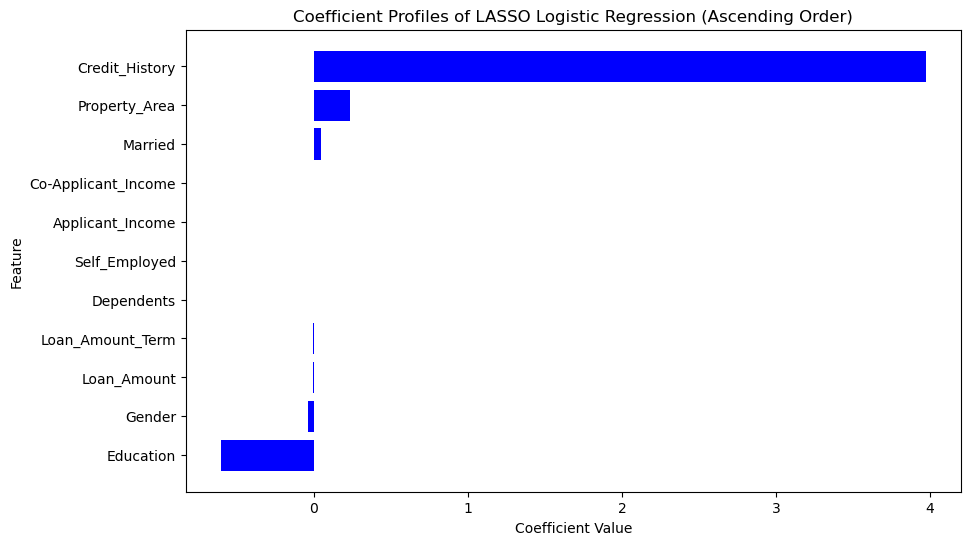

In [71]:
# Features sorted based on their coefficients in ascending order
sorted_indices = coefficients.argsort()
sorted_features = feature_names[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

# Plot of coefficient profiles in ascending order
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_coefficients, color='blue')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Coefficient Profiles of LASSO Logistic Regression (Ascending Order)")
plt.show()


In [57]:
# Create the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model on the training data
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

In [58]:
# Make predictions on the test set
y_pred = gb_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Print the classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7777777777777778

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.46      0.50        24
           1       0.84      0.88      0.86        75

    accuracy                           0.78        99
   macro avg       0.69      0.67      0.68        99
weighted avg       0.77      0.78      0.77        99


Confusion Matrix:
[[11 13]
 [ 9 66]]


Paramter Tuning 

In [59]:
param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of the regularization strength (1/λ)
    'penalty': ['l1'],  # Use L1 (LASSO) regularization
    'solver': ['liblinear']  # Use 'liblinear' solver for L1 regularization
}


lasso_logreg = LogisticRegression()


In [60]:
grid_search_logreg = GridSearchCV(estimator=lasso_logreg, param_grid=param_grid_logreg, cv=5, scoring='accuracy')
grid_search_logreg.fit(X_train, y_train)

# Get the best hyperparameters from the GridSearchCV
best_params_logreg = grid_search_logreg.best_params_
print("Best Hyperparameters for LASSO Logistic Regression:", best_params_logreg)


Best Hyperparameters for LASSO Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [61]:
# Create the LASSO Logistic Regression model with the best hyperparameters
best_logreg_model = LogisticRegression(penalty='l1', C=best_params_logreg['C'], solver='liblinear')



In [62]:
# Train the best LASSO Logistic Regression model on the training data
best_logreg_model.fit(X_train, y_train)

# Train the best Gradient Boosting model on the training data
best_gb_model.fit(X_train, y_train)


NameError: name 'best_gb_model' is not defined

GBoost

In [197]:
param_grid_gb = {
    'n_estimators': [50, 100, 150],  # Number of estimators (trees) in the ensemble
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate (shrinkage factor)
    'max_depth': [3, 4, 5]  # Maximum depth of the individual trees
}


In [198]:
gb_model = GradientBoostingClassifier(random_state=42)


In [199]:
grid_search_gb = GridSearchCV(estimator = gb_model, param_grid = param_grid_gb, cv = 5, scoring = 'accuracy')
grid_search_gb.fit(X_train, y_train)

# Get the best hyperparameters from the GridSearchCV
best_params_gb = grid_search_gb.best_params_
print("Best Hyperparameters for Gradient Boosting:", best_params_gb)


Best Hyperparameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50}


In [67]:
# Make predictions using the best models on the test set
y_pred_logreg = best_logreg_model.predict(X_test)
y_pred_gb = best_gb_model.predict(X_test)

# Evaluate the best models' performance using accuracy
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

print("Accuracy of Best LASSO Logistic Regression Model:", accuracy_logreg)
print("Accuracy of Best Gradient Boosting Model:", accuracy_gb)

NameError: name 'best_gb_model' is not defined

In [ ]:
# Compare the model performance based on accuracy
if accuracy_logreg > accuracy_gb:
    print("Best Model: LASSO Logistic Regression")
elif accuracy_logreg < accuracy_gb:
    print("Best Model: Gradient Boosting")
else:
    print("Both Models Perform Equally Well")


In [ ]:
# Save the model to a file
model_file = 'loan_approval_model.pkl'
joblib.dump(model, model_file)

# Load the model
loaded_model = joblib.load(model_file)

def main():
    st.title('Loan Approval Prediction App')
    st.write('Enter the required information to get a loan approval prediction.')

    # Create input fields for user to enter data
    loan_amount = st.number_input('Loan Amount', min_value=1, step=1)
    credit_score = st.number_input('Credit Score', min_value=300, max_value=850, step=1)
    # Add more input fields based on your model's feature requirements

    # Example: Create a dropdown for selecting gender
    gender = st.selectbox('Gender', ['Male', 'Female'])

    # Create a submit button
    if st.button('Predict Loan Approval'):
        # Create a feature vector from user inputs
        feature_vector = np.array([[loan_amount, credit_score, gender]])  # Update with appropriate features

        # Preprocess the input data (if needed) using the same preprocessing used during model training

        # Make prediction using the model
        prediction = model.predict(feature_vector)

        # Display the prediction
        if prediction[0] == 1:
            st.write('Congratulations! Your loan is approved.')
        else:
            st.write('Sorry, your loan application is rejected.')

if __name__ == '__main__':
    main()


Run the Streamlit App
To run your Streamlit app, open a terminal or command prompt, navigate to the directory where app.py is located, and run